In [2]:
using CSV, DataFrames, CairoMakie, NonlinearSolve, QuadGK, ForwardDiff

In [3]:
Λ = 0.65
Nf = 2
Nc = 3
G = (9/2)*2.0 / Λ^2 # ???

# Δ is actually |Δ|
Epm(Δ, μ, λ, k, s) = 1/2 * (s*sqrt((k - λ - μ)^2 + 8Nf*Δ^2) + k + λ - μ)
E(μ, k) = k - μ
σ(Δ, μ, λ, k) = sqrt((k - λ - μ)^2 + 8Nf*Δ^2)

θ(x) = x > 0 ? 1 : 0
f0(Δ, μ, λ, k) = θ(-k - λ + μ - σ(Δ, μ, λ,k))*Epm(Δ, μ, λ, k, 1) + θ(-k - λ + μ + σ(Δ, μ, λ,k))*Epm(Δ, μ, λ, k, -1) + θ(μ - k)*E(μ, k)
#I'm not sure if forwarddiff will catch those theta functions
df0dλ(Δ, μ, λ, k) = ForwardDiff.derivative(λi -> f0(Δ, μ, λi, k), λ)

function Ω(Δ, μ, λ)
    I1 = quadgk(k -> k^2*df0dλ(Δ, μ, λ, k), 0, Λ)[1]
    I2 = quadgk(k -> k^2*f0(Δ, μ, λ, k), 0, Λ)[1]

    s = 1
    if λ < 0
        s = -1
    end

    -λ*Nc/π^2 * I1 + Nc/π^2 * I2 + 8Nf/G * Δ^2
end

gap(Δ, μ, λ) = ForwardDiff.derivative(Δi -> Ω(Δi, μ, λ), Δ)

function solvegap(μ, λ)
    xmin1 = -0.005
    xmax1 = 0.005
    xmin2 = 0.005
    xmax2 = 0.03

    f(x, param) = gap(x[1], μ, λ)

    xguess = [(xmin1, xmax1), (xmin2, xmax2)]
    if (gap(xmin2, μ, λ) * gap(xmax2, μ, λ) > 0)
        xguess = [(xmin1, xmax1)]
    end

    sols = zeros(size(xguess))
    Threads.@threads for i in eachindex(sols)
        prob = IntervalNonlinearProblem(f, xguess[i], ())
        sol = solve(prob)
        sols[i] = sol.u
    end

    Ωsols = [Ω(sol, μ, λ) for sol in sols]
    return sols[findmin(Ωsols)[2]]
end

solvegap (generic function with 1 method)

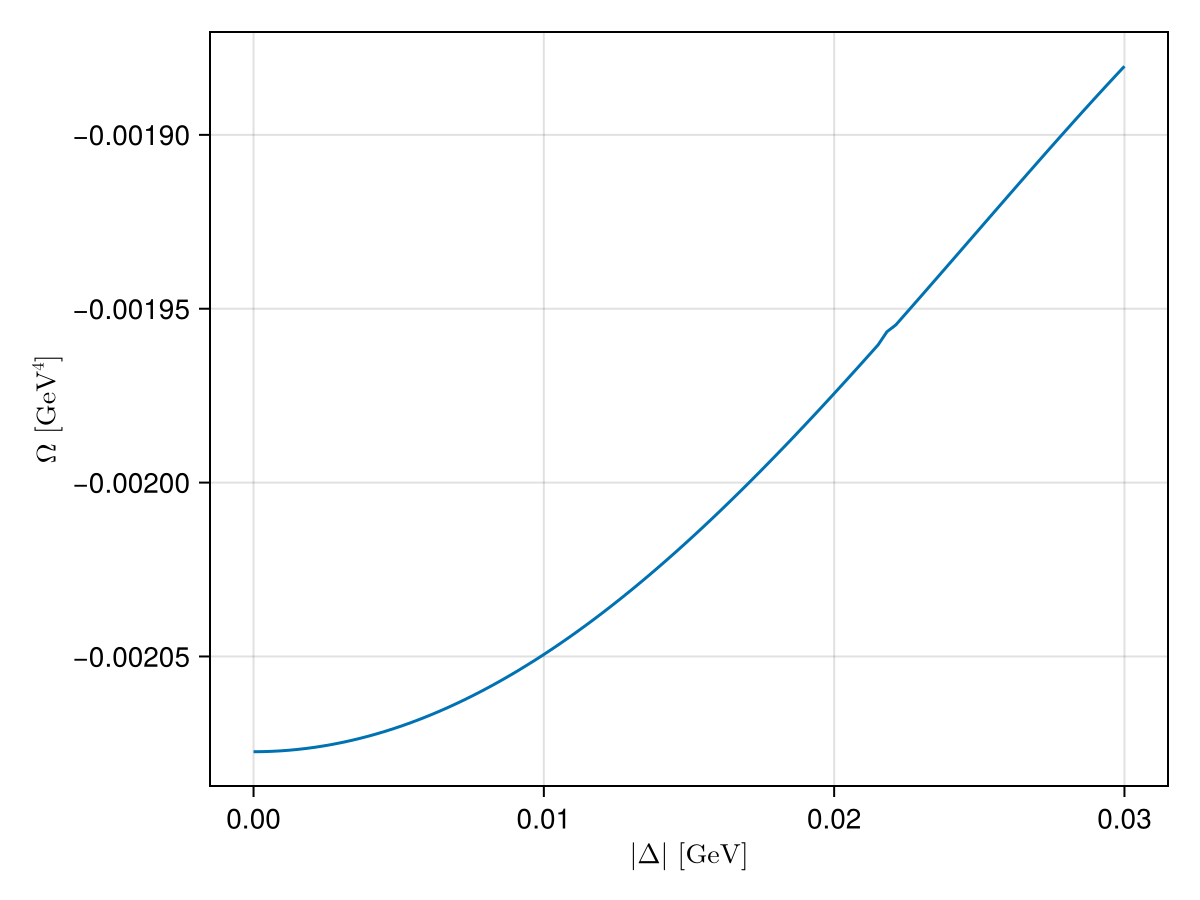

In [6]:
Δvals = range(0.0, 0.030, length=100)
μi = 0.45
λi = 0.05

Ωvals = zeros(size(Δvals))
Threads.@threads for i in eachindex(Δvals)
    Δ = Δvals[i]
    Ωvals[i] = Ω(Δ, μi, λi)
end

fig = Figure()
ax = Axis(fig[1, 1],
    xlabel = L"$|\Delta|$ [GeV]",
    ylabel = L"$\Omega$ [GeV$^4$]"
)

lines!(ax, Δvals, Ωvals)
fig

In [5]:
μi = 0.35
λi = 0.015
Δsol = solvegap(μi, λi)
println(Δsol)

0.0


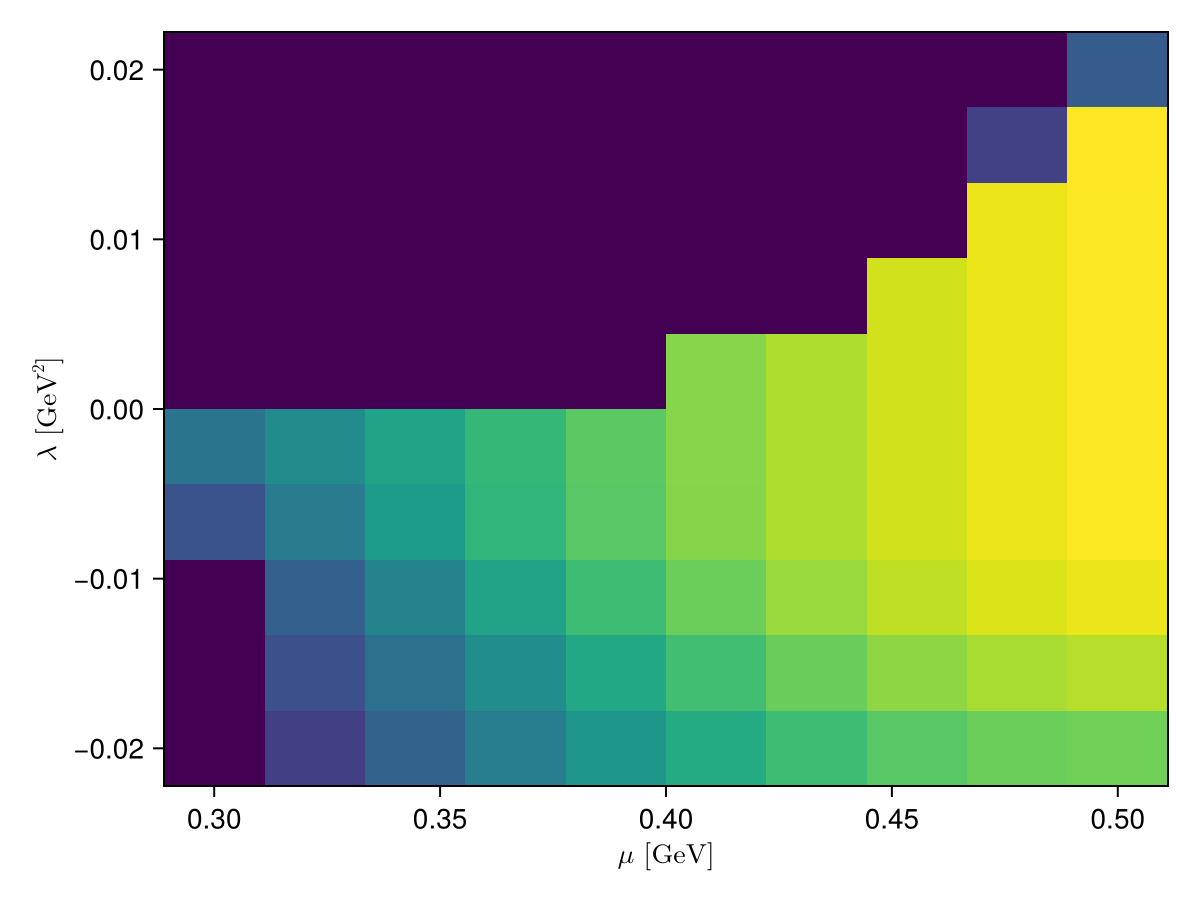

In [6]:
ngrid1 = 10
ngrid2 = 10

μvals = range(0.3, 0.5, length=ngrid1)
λvals = range(-0.020, 0.020, length=ngrid2)
Δsols = zeros(ngrid1, ngrid2)

Threads.@threads for i in 1:ngrid1
    Threads.@threads for j in 1:ngrid2
        Δsols[i, j] = solvegap(μvals[i], λvals[j])
    end
end

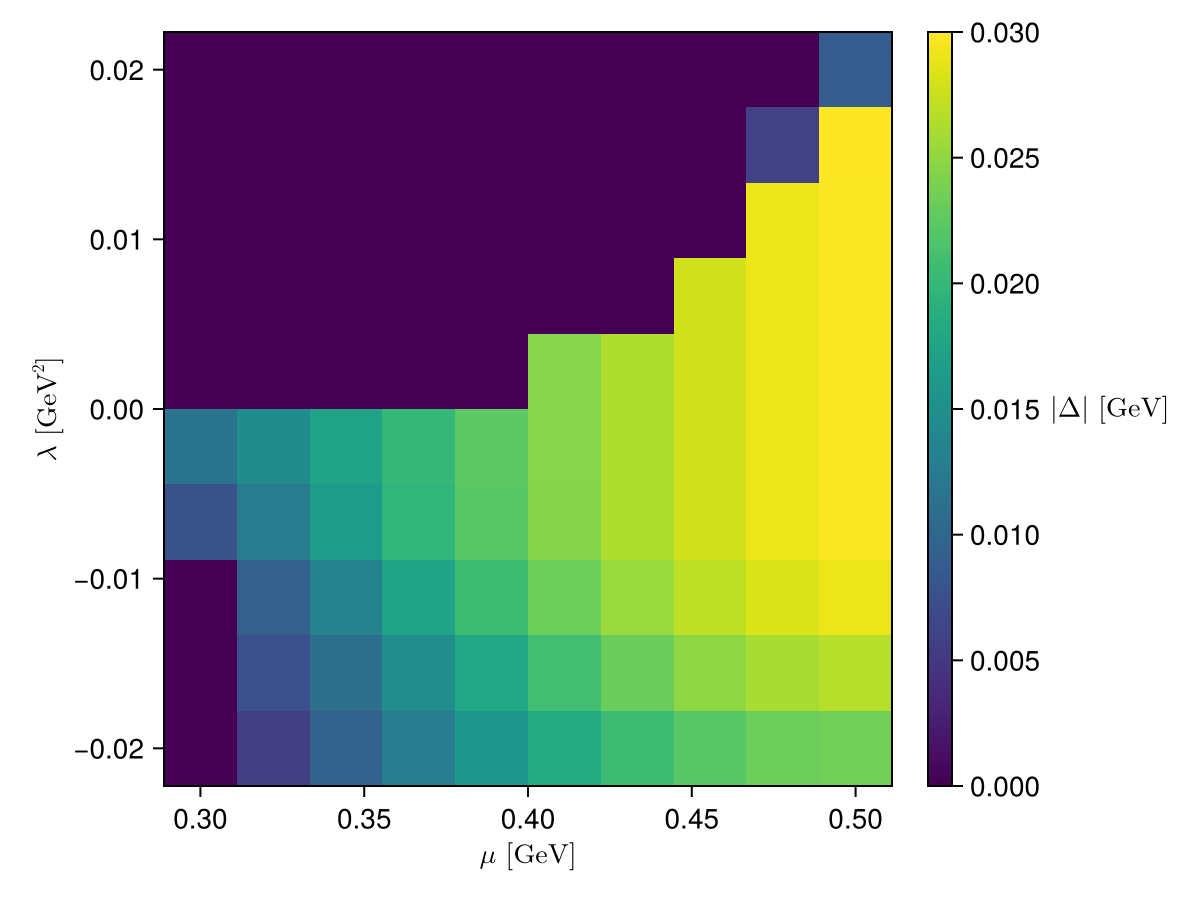

In [14]:
fig = Figure()
ax = Axis(fig[1, 1],
    xlabel = L"$\mu$ [GeV]",
    ylabel = L"$\lambda$ [GeV$^2$]"
)

heatmap!(ax, μvals, λvals, Δsols)

Colorbar(fig[1,2], limits=(0, 0.030), label=L"$|\Delta|$ [GeV]", labelrotation=0)
save("gapheatmap.png", fig)
fig